In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [29]:
x_train = pd.read_csv(
  "../data/processed/x_train_w_OHE.csv", index_col=0, dtype=str)
x_test = pd.read_csv(
  "../data/processed/x_test_w_OHE.csv", index_col=0, dtype=str)
y_train = pd.read_csv(
  "../data/processed/y_train.csv", index_col=0, dtype=float
  ).squeeze("columns").reset_index(drop=True)
y_test = pd.read_csv(
  "../data/processed/y_test.csv", index_col=0, dtype=float
).squeeze("columns").reset_index(drop=True)

In [30]:
def get_correct_types_x(df, numeric_cols):
    for col in ['deenergize_time', 'restoration_time']:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')
    for col in numeric_cols:
        df[col] = df[col].astype(float)
    return df
numeric_cols = [
    'hftd_tier', 'total_affected', 'residential_affected',
    'longitude', 'latitude', 'total_pop', 'median_age', 'median_income',
    'white_pct', 'tmin_d-5', 'tmax_d-5', 'wspd_d-5', 'tmin_d-4', 'tmax_d-4',
    'wspd_d-4', 'tmin_d-3', 'tmax_d-3', 'wspd_d-3', 'tmin_d-2', 'tmax_d-2',
    'wspd_d-2', 'tmin_d-1', 'tmax_d-1', 'wspd_d-1', 'day_in_year'
]
zip_cols = x_train.columns[
    [re.search('zip_is', col) is not None for col in x_train.columns]
]
x_train = get_correct_types_x(x_train, numeric_cols)
x_test = get_correct_types_x(x_test, numeric_cols)
rel_x_train = x_train[numeric_cols]
rel_x_test = x_test[numeric_cols]

In [31]:
scaler = StandardScaler()
scaler.fit(rel_x_train)
scaled_train_x = scaler.transform(rel_x_train)
scaled_test_x = scaler.transform(rel_x_test)

In [32]:
best_preds = np.loadtxt("../data/predictions/xgboost_final_preds.csv")

In [33]:
resids = y_test - best_preds

In [34]:
# Take 10% of observations with worst predictions
top10_pct_off = np.argsort(np.abs(np.array(resids)))[-int(0.1 * len(resids))::][::-1]
extreme_resids = resids[top10_pct_off]
extreme_x = x_test.iloc[top10_pct_off, :]
extreme_y = y_test[top10_pct_off]

# Take remaining 90% predictions for feature comparison
other_90_idx = np.argsort(np.abs(np.array(resids)))[ : int(0.9 * len(resids))]
other_90_x = x_test.iloc[other_90_idx, :]
other_90_y = y_test[other_90_idx]


In [59]:
# Percentage of zip code resulting in "extreme" errors vs. percentage 
# appearing in the full data set
zip_code_errors = pd.merge(
  (extreme_x.zip_code.value_counts() /
    extreme_x.zip_code.value_counts().sum()),
  (x_test.zip_code.value_counts() / 
    x_test.zip_code.value_counts().sum()),
  how='inner', left_index=True, right_index=True, 
).rename(columns={'zip_code_x': 'extreme', 'zip_code_y': 'all'})
zip_code_errors['pct_diff'] = zip_code_errors['extreme']/ zip_code_errors['all']
# zip_code_errors['total_pop'] =  # ADD TOTAL_POP FROM X_TEST TO THIS DATAFRAME?

print(zip_code_errors.sort_values('pct_diff', ascending=False).iloc[0:25,])

        extreme       all   pct_diff
93647  0.025641  0.002545  10.076923
95209  0.025641  0.002545  10.076923
95468  0.025641  0.002545  10.076923
95987  0.025641  0.002545  10.076923
95939  0.025641  0.002545  10.076923
96076  0.025641  0.002545  10.076923
95327  0.025641  0.002545  10.076923
95425  0.025641  0.002545  10.076923
92356  0.051282  0.005089  10.076923
93660  0.051282  0.005089  10.076923
94025  0.051282  0.007634   6.717949
96033  0.025641  0.005089   5.038462
95663  0.025641  0.005089   5.038462
96021  0.025641  0.005089   5.038462
95442  0.025641  0.005089   5.038462
94803  0.025641  0.005089   5.038462
95526  0.025641  0.005089   5.038462
95020  0.025641  0.005089   5.038462
95966  0.153846  0.035623   4.318681
95035  0.025641  0.007634   3.358974
95682  0.025641  0.007634   3.358974
96069  0.025641  0.007634   3.358974
94559  0.025641  0.010178   2.519231
95603  0.025641  0.010178   2.519231
95667  0.051282  0.020356   2.519231


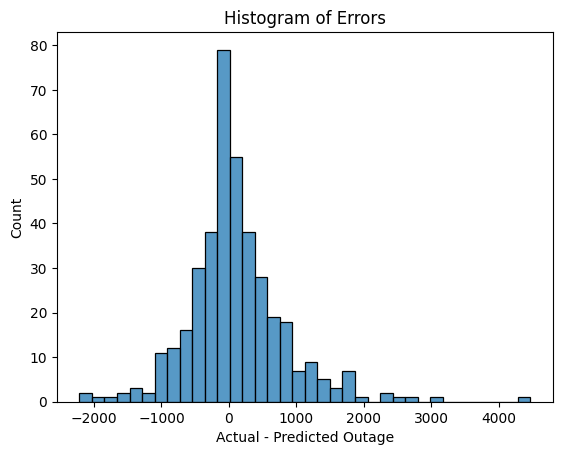

In [36]:
sns.histplot(resids)
plt.title("Histogram of Errors")
plt.xlabel("Actual - Predicted Outage")
plt.savefig("../data/predictions/xgb_errors.png")
plt.show()

In [38]:
# extreme_x

In [52]:
numeric_diffs = pd.DataFrame(
  [(feat, np.median(extreme_x[feat]), np.median(other_90_x[feat]))
   for feat in numeric_cols],
  columns=['feature', 'extreme_median', 'other_90_median']
)
numeric_diffs['pct_diff'] = (
  (numeric_diffs.extreme_median - numeric_diffs.other_90_median) / 
   numeric_diffs.other_90_median)
numeric_diffs['abs_diff'] = np.abs(numeric_diffs.pct_diff)
print(
  numeric_diffs.sort_values('abs_diff', ascending=False). \
    drop(columns=['abs_diff']).reset_index(drop=True)
)


                 feature  extreme_median  other_90_median  pct_diff
0               wspd_d-2       10.100000         7.100000  0.422535
1              total_pop    26062.000000     20681.000000  0.260191
2               wspd_d-1        5.300000         6.900000 -0.231884
3               tmin_d-4        8.300000        10.000000 -0.170000
4               tmin_d-2       12.200000        10.600000  0.150943
5               wspd_d-4        6.000000         7.000000 -0.142857
6         total_affected      731.000000       822.000000 -0.110706
7               wspd_d-5        8.200000         7.600000  0.078947
8   residential_affected      650.000000       704.000000 -0.076705
9          median_income    65417.000000     70656.000000 -0.074148
10              tmin_d-1        8.900000         9.600000 -0.072917
11              tmax_d-3       30.000000        28.300000  0.060071
12              tmin_d-3       10.000000        10.600000 -0.056604
13              tmin_d-5        8.900000        